In [1]:
import keras
from keras.applications.resnet50 import ResNet50
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
import matplotlib.pyplot as plt
from six.moves import cPickle as pickle
from keras.models import Model

Using TensorFlow backend.


In [2]:


resnet = ResNet50(include_top=False
                  ,input_shape=(64, 64, 3)
                  ,weights='imagenet'
                  ,pooling='avg')

for layer in resnet.layers:
    layer.trainable=True

fc1000_2 = Dense(1000, activation='relu', name='fc1000_2')(resnet.output)
fc256 = Dense(256, activation='relu', name='fc256')(fc1000_2)
output = Dense(units=1, activation='sigmoid', name='last')(fc256)

model = Model(resnet.input, output, name='whole_Model')

# Show final model
model.summary()

# initiate optimizer
opt = keras.optimizers.adam(lr=0.001, decay=1e-6)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
_____________________________________

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

batch_size = 32
input_size=(64, 64)

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
 
test_datagen = ImageDataGenerator(rescale=1. / 255)
 
training_set = train_datagen.flow_from_directory('PS-Battles/train',
                                                 target_size=input_size,
                                                 batch_size=batch_size,
                                                 class_mode='binary')
 
test_set = test_datagen.flow_from_directory('PS-Battles/test',
                                            target_size=input_size,
                                            batch_size=batch_size,
                                            class_mode='binary')


Found 56596 images belonging to 2 classes.
Found 24229 images belonging to 2 classes.


In [4]:
history = model.fit_generator(training_set,
                         steps_per_epoch=3000,
                         epochs=10,
                         validation_data=test_set,
                         validation_steps=1000,
                         workers=12
                         )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
3000/3000 [==============================] - 790s 263ms/step - loss: 0.4372 - acc: 0.8654 - val_loss: 0.4167 - val_acc: 0.8666
Epoch 2/10
3000/3000 [==============================] - 780s 260ms/step - loss: 0.3968 - acc: 0.8661 - val_loss: 0.4021 - val_acc: 0.8655
Epoch 3/10
3000/3000 [==============================] - 777s 259ms/step - loss: 0.3962 - acc: 0.8661 - val_loss: 0.3954 - val_acc: 0.8656
Epoch 4/10
3000/3000 [==============================] - 778s 259ms/step - loss: 0.3940 - acc: 0.8668 - val_loss: 0.3977 - val_acc: 0.8665
Epoch 5/10
3000/3000 [==============================] - 780s 260ms/step - loss: 0.3964 - acc: 0.8654 - val_loss: 0.4008 - val_acc: 0.8670
Epoch 6/10
3000/3000 [==============================] - 779s 260ms/step - loss: 0.3950 - acc: 0.8665 - val_loss: 0.4026 - val_acc: 0.8644
Epoch 7/10
3000/3000 [==============================] - 781s 260ms/step - loss: 0.3949 - acc: 0.8660 - val_loss: 0.4048 - va

In [5]:
model_backup_path = 'PS-Battles/ResNet_TL.h5'
model.save(model_backup_path)


def plot_model(model_details):

    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
   

    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')

    # Show the plot
    plt.show()

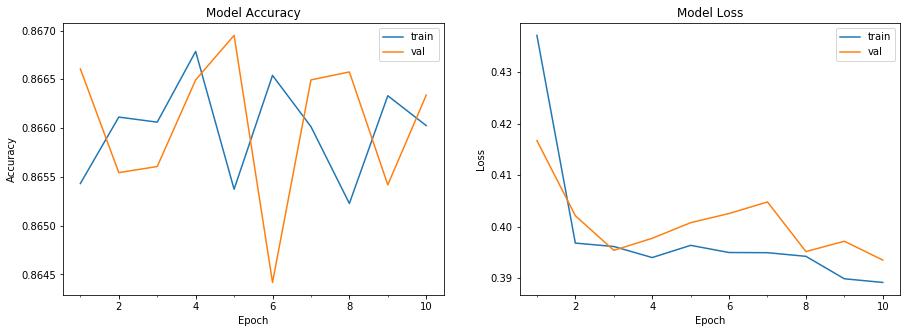

In [6]:
import numpy as np

plot_model(history)

In [7]:
from sklearn.metrics import classification_report, confusion_matrix

#Confution Matrix and Classification Report

Y_pred = model.predict_generator(test_set, 24229 // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = ['Real', 'PS']
print(classification_report(test_set.classes, y_pred, target_names=target_names))


Confusion Matrix
[[20982     0]
 [ 3247     0]]
Classification Report
              precision    recall  f1-score   support

        Real       0.87      1.00      0.93     20982
          PS       0.00      0.00      0.00      3247

   micro avg       0.87      0.87      0.87     24229
   macro avg       0.43      0.50      0.46     24229
weighted avg       0.75      0.87      0.80     24229



/home/mackaber/anaconda3/envs/DeepLearning/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
